# Introduzione

Questo progetto mira a condurre un’analisi approfondita del dataset . . .

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.plotting import parallel_coordinates

# --- Per il Caricamento Dati  ---
from sklearn.datasets import fetch_openml

# --- Per Preprocessing e Valutazione ---
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- Per i Modelli di Classificazione ---
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from scipy.stats import loguniform, randint # Fondamentale per le distribuzioni
from sklearn.model_selection import RandomizedSearchCV

In [112]:
## --- ANALISI ESPLORATIVA ---

try:
    data_bunch = fetch_openml(name ='banknote-authentication', as_frame=True, parser='auto')
except Exception as e:
    print(f"Errore nel caricamento dati: {e}")

# 2. DataFrame
# Keep the full DataFrame which contains both features and the target.
df = data_bunch.frame.copy() # Use .copy() to avoid potential SettingWithCopyWarning later if we modify df.

# 3. Colonna target (identify its original name)
class_column_name = data_bunch.target_names[0]
print(f"Identificata la colonna target: '{class_column_name}'")

# 4. Controllo nomi colonne
new_column_names = {
    'V1': 'variance',
    'V2': 'skewness',
    'V3': 'curtosis',
    'V4': 'entropy'
}

# Apply renaming to the DataFrame.
# This will rename 'V1' through 'V4'. The target column will be kept as its original name (e.g., 'Class') for now.
df = df.rename(columns=new_column_names)

# Ensure the target column is named 'target' for consistency in later steps.
# If the original target column name is not 'target', rename it.
if class_column_name != 'target' and class_column_name in df.columns:
    df.rename(columns={class_column_name: 'target'}, inplace=True)
    class_column_name = 'target' # Update the variable to reflect the new name

# 5. Analisi preliminare
print("\n--- Prime 5 righe del DataFrame Combinato ---")
print(df.head())

print("\n--- Informazioni (Tipi di dati e Valori Mancanti) ---")
df.info()

# 6. Analisi sbilanciamento classi
print("\n--- Distribuzione delle Classi (Valori Originali) ---")
# Use the updated class_column_name for accessing the target column
print(df[class_column_name].value_counts())

Identificata la colonna target: 'Class'

--- Prime 5 righe del DataFrame Combinato ---
   variance  skewness  curtosis  entropy target
0   3.62160    8.6661   -2.8073 -0.44699      1
1   4.54590    8.1674   -2.4586 -1.46210      1
2   3.86600   -2.6383    1.9242  0.10645      1
3   3.45660    9.5228   -4.0112 -3.59440      1
4   0.32924   -4.4552    4.5718 -0.98880      1

--- Informazioni (Tipi di dati e Valori Mancanti) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   variance  1372 non-null   float64 
 1   skewness  1372 non-null   float64 
 2   curtosis  1372 non-null   float64 
 3   entropy   1372 non-null   float64 
 4   target    1372 non-null   category
dtypes: category(1), float64(4)
memory usage: 44.5 KB

--- Distribuzione delle Classi (Valori Originali) ---
target
1    762
2    610
Name: count, dtype: int64


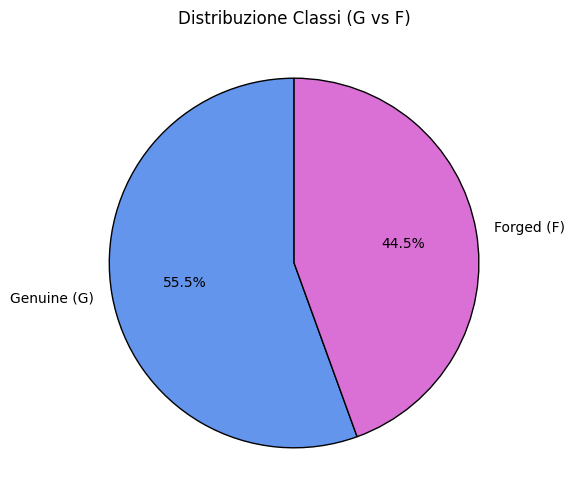

In [113]:
## VISUALIZZAZIONI (Blocco 2.1: Grafico a Torta) ---

# 1. Mappatura delle classi
class_map = {'1': 'Genuine (G)', '2': 'Forged (F)'}
color_map_dict = {'Genuine (G)': 'cornflowerblue', 'Forged (F)': 'orchid'}

# Copia e crea la colonna etichettata
df_plot = df.copy()
df_plot['Diagnosis_Label'] = df[class_column_name].map(class_map)

# 2. Grafico a Torta (Distribuzione Classi)
plt.figure(figsize=(6, 6))

# Conta le classi e ordina
counts = df_plot['Diagnosis_Label'].value_counts()

# Applica la color map in base all’ordine delle etichette
colors = [color_map_dict[label] for label in counts.index]

# Crea il grafico
counts.plot.pie(
    autopct='%1.1f%%',
    colors=colors,
    wedgeprops={'edgecolor': 'black'},
    startangle=90
)

plt.title('Distribuzione Classi (G vs F)')
plt.ylabel('')
plt.show()

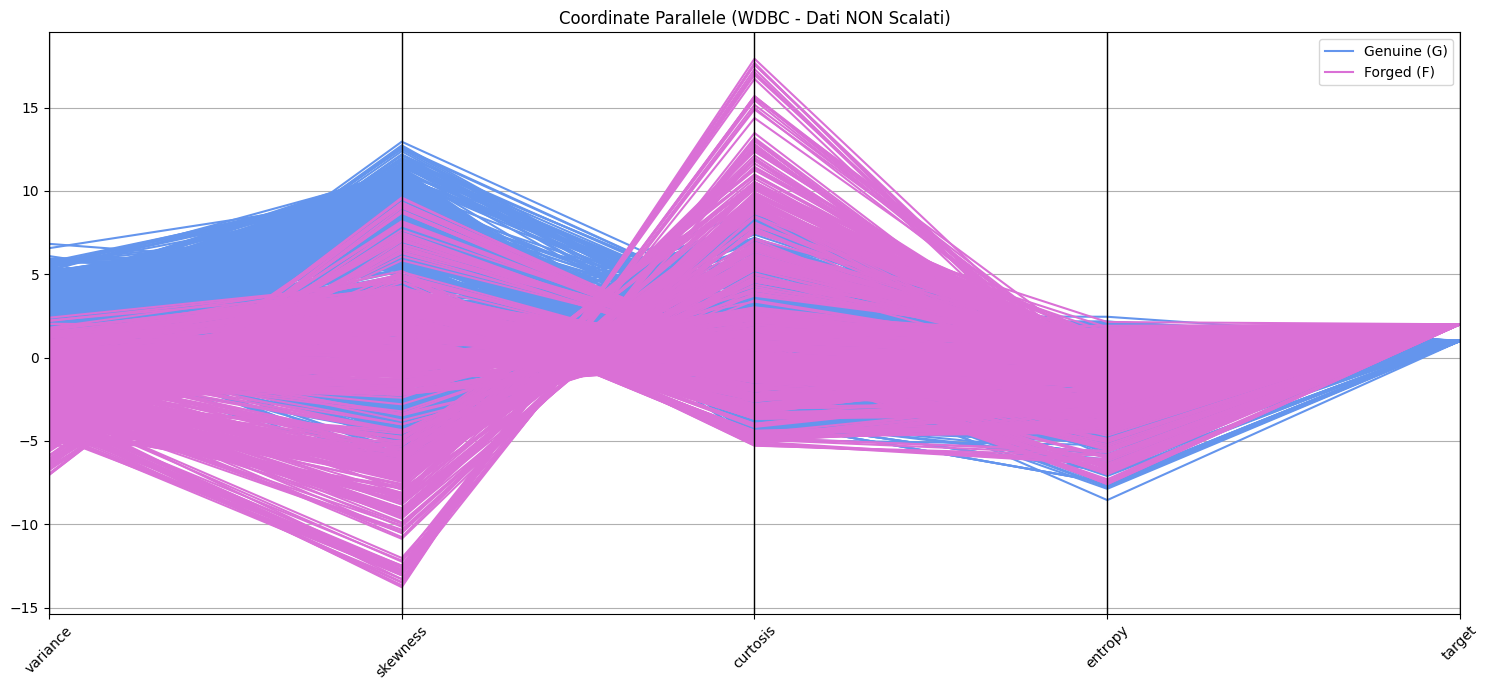

In [114]:
## VISUALIZZAZIONI (Blocco 2.2: Coordinate Parallele - NON Scalati) ---

plt.figure(figsize=(15, 7))

# Ottieni l'ordine delle classi effettive nel DataFrame
class_order = df_plot['Diagnosis_Label'].unique()

# Applica la color map in base all'ordine
colors = [color_map_dict[label] for label in class_order]

# Grafico delle coordinate parallele
parallel_coordinates(df_plot, 'Diagnosis_Label', color=colors)

plt.title('Coordinate Parallele (WDBC - Dati NON Scalati)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

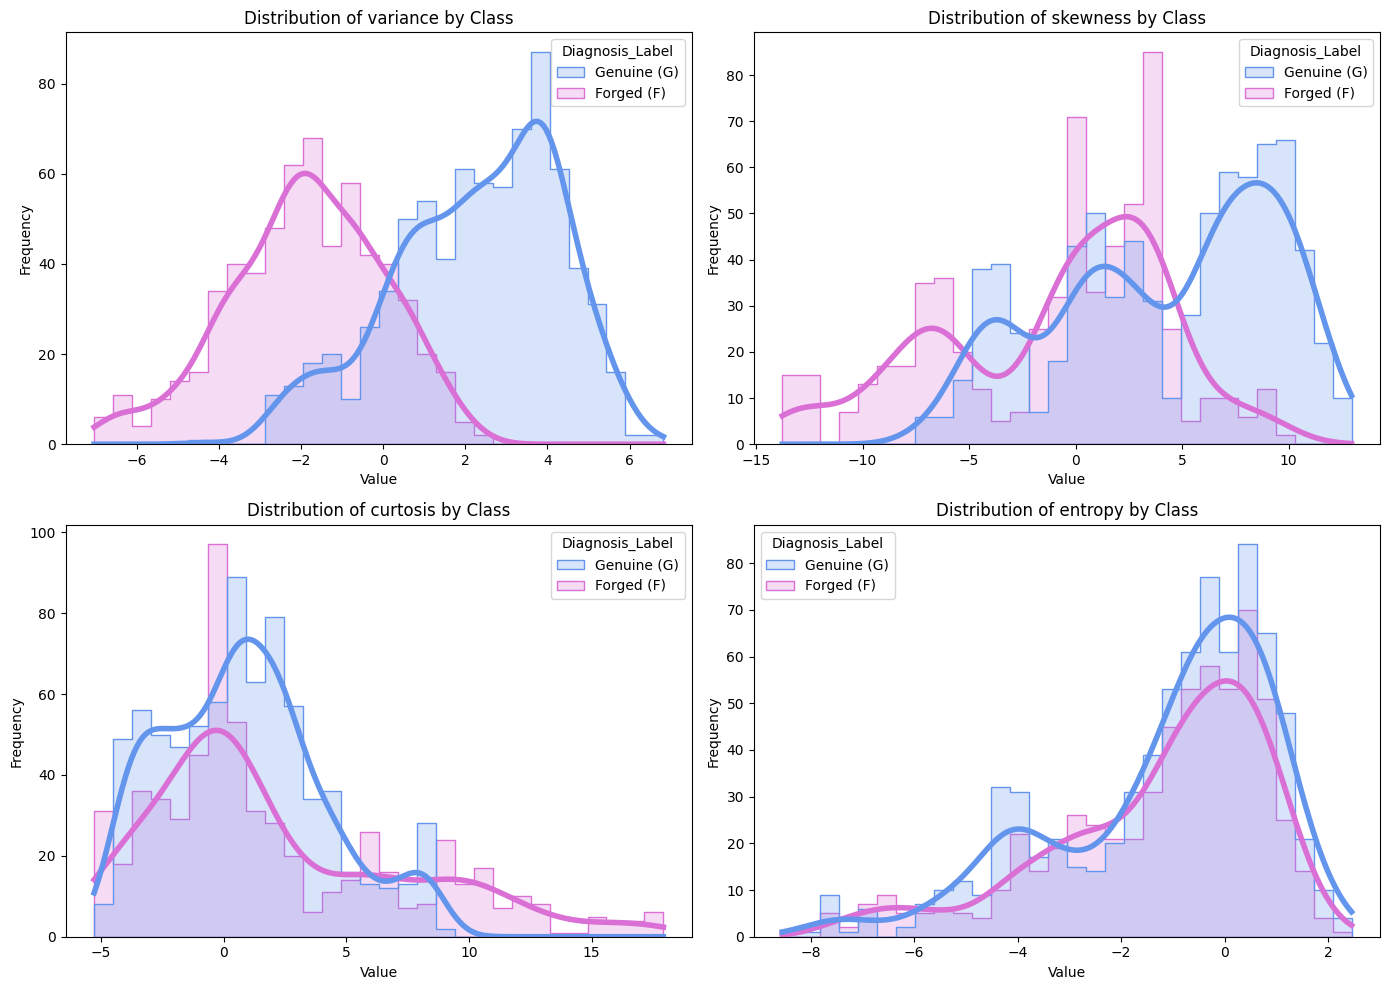

In [115]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

# Define the feature columns to plot (excluding the target column)
feature_cols = ['variance', 'skewness', 'curtosis', 'entropy']

# Define the palette using the already available color_map_dict
plot_palette = {label: color for label, color in color_map_dict.items()}

for i, feature in enumerate(feature_cols):
    sns.histplot(data=df_plot, x=feature, hue='Diagnosis_Label', ax=axes[i], kde=True, bins=30, palette=plot_palette, line_kws={'linewidth': 4}, element='step')
    axes[i].set_title(f'Distribution of {feature} by Class')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

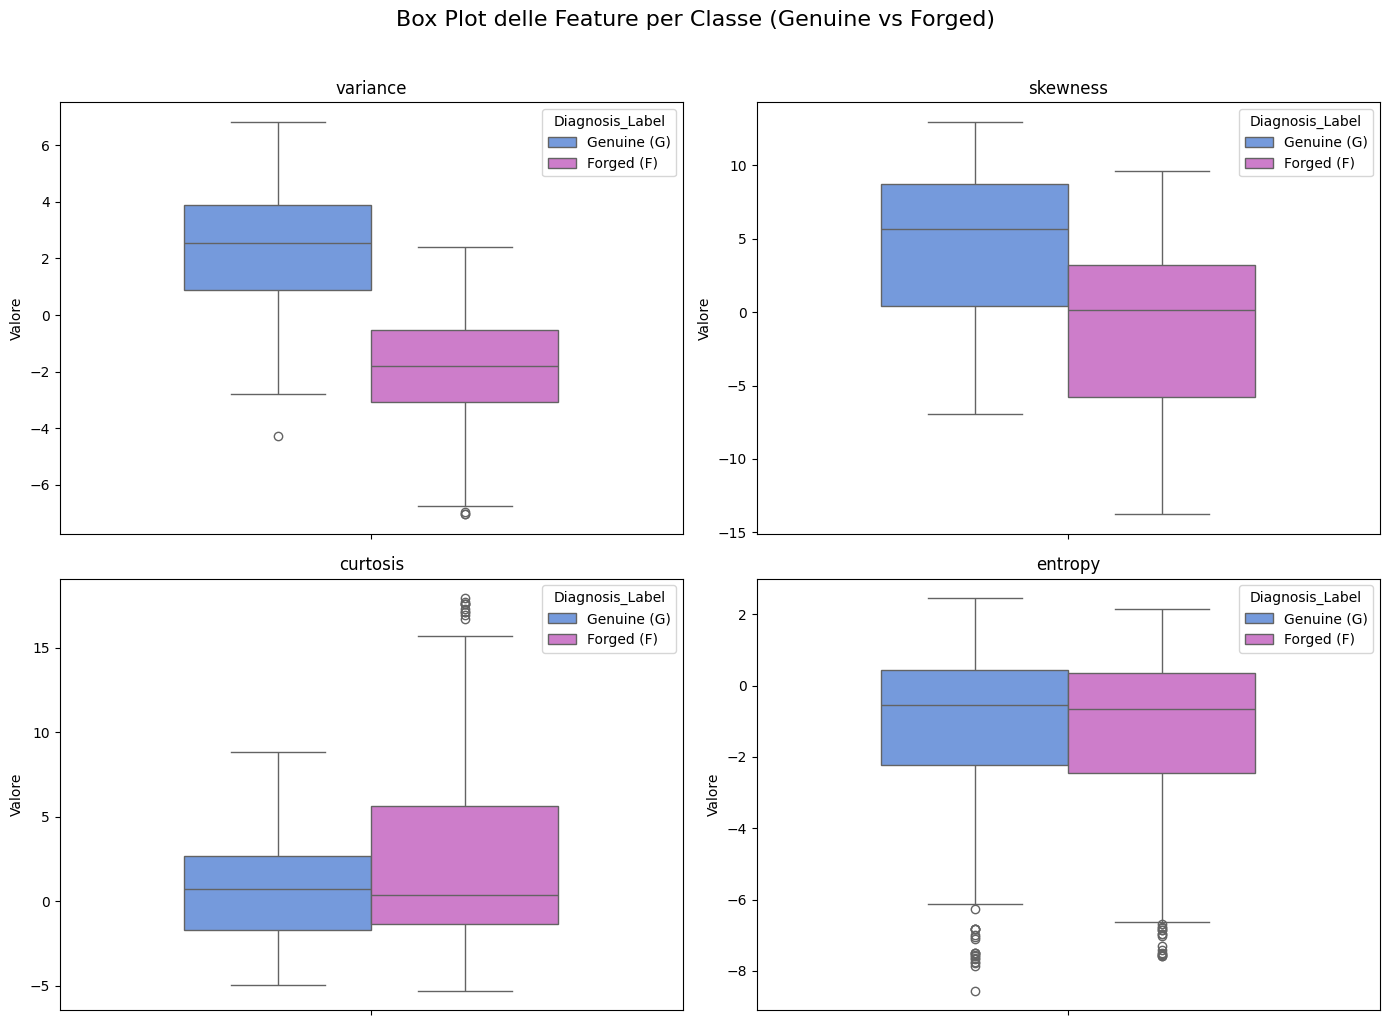

In [116]:
## --- VISUALIZZAZIONI (Blocco 2.5: Box Plot) ---

# Define the feature columns (if not already defined from previous cells)
feature_column_names = ['variance', 'skewness', 'curtosis', 'entropy']

# Selezioniamo le feature da plottare
features_to_plot = feature_column_names

plt.figure(figsize=(14, 10))
for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(
        df_plot,
        hue='Diagnosis_Label',
        y=feature,
        palette=color_map_dict,
        width=0.6
    )
    plt.title(feature)
    plt.xlabel('')
    plt.ylabel('Valore')

plt.suptitle('Box Plot delle Feature per Classe (Genuine vs Forged)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

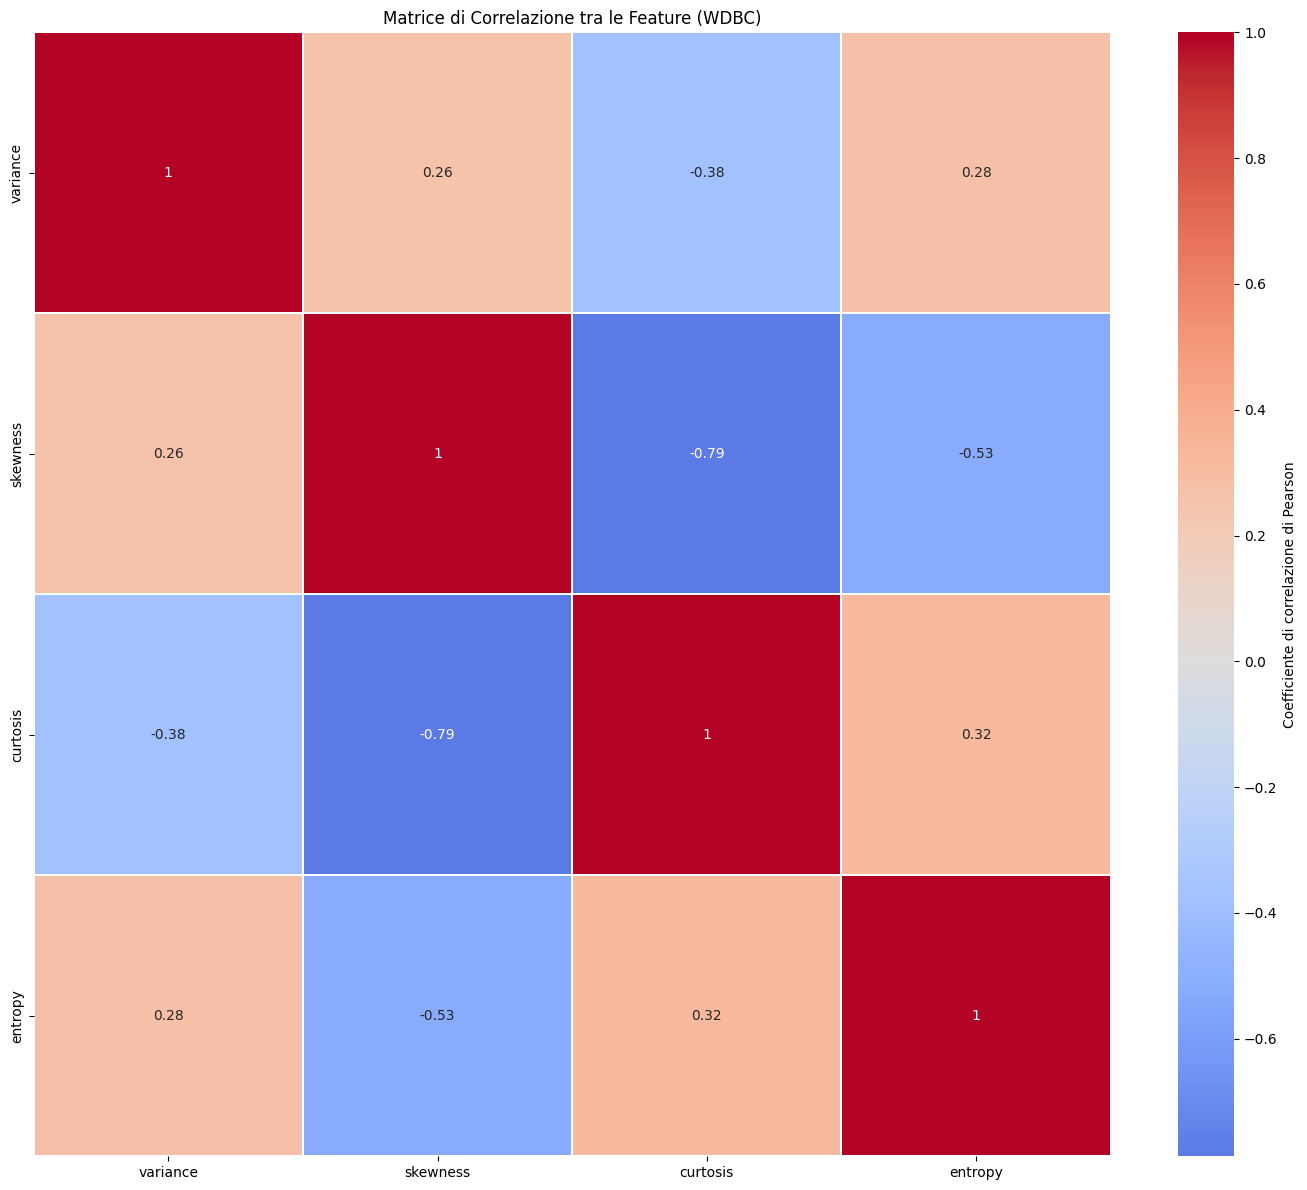

In [117]:
## --- VISUALIZZAZIONI (Blocco 2.4: Matrice di Correlazione) ---

# Calcolo della matrice di correlazione
corr_matrix = df[feature_column_names].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    annot=True,
    linewidths=0.3,
    cbar_kws={'label': 'Coefficiente di correlazione di Pearson'}
)
plt.title('Matrice di Correlazione tra le Feature (WDBC)')
plt.tight_layout()
plt.show()

In [118]:
## --- PREPROCESSING ---
RANDOM_STATE = 42
TEST_SIZE = 0.2  # 20% per il test set

# 1. Separa X (features) e y (target) dal DataFrame originale
X = df.drop(class_column_name, axis=1)
y = df[class_column_name]

# 2. Encoding del Target (da '2'/'1' a 1/0)
# '2' (Maligno) -> 1
# '1' (Benigno) -> 0
y_numeric = y.map({'2': 1, '1': 0})
print(f"\nTarget convertito in numerico (0=Benigno, 1=Maligno):\n{y_numeric.value_counts()}")


# 3. Divisione in Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_numeric,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_numeric
)

print(f"\nDati di Addestramento (X_train): {X_train.shape}")
print(f"Target di Addestramento (y_train): {y_train.shape}")
print(f"Dati di Test (X_test): {X_test.shape}")
print(f"Target di Test (y_test): {y_test.shape}")



Target convertito in numerico (0=Benigno, 1=Maligno):
target
0    762
1    610
Name: count, dtype: int64

Dati di Addestramento (X_train): (1097, 4)
Target di Addestramento (y_train): (1097,)
Dati di Test (X_test): (275, 4)
Target di Test (y_test): (275,)


In [119]:
#4. Standardizzazione delle variabili
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [120]:
def evaluate_model(model, X_test, y_test, average='macro', verbose=True):
    """
    Valuta un modello calcolando Accuracy, Precision, Recall e F1-score.
    - average='macro' funziona perfettamente sia per binario che multiclass.
    """
    y_pred = model.predict(X_test)

    accuracy  = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred, average=average), 3)
    recall    = round(recall_score(y_test, y_pred, average=average), 3)
    f1        = round(f1_score(y_test, y_pred, average=average), 3)



    if verbose:
        print(f"Accuracy:  {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall:    {recall}")
        print(f"F1-score:  {f1}")


    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [121]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),

    "KNN (k=5)": KNeighborsClassifier(),

    "SVM (RBF)": SVC(random_state=RANDOM_STATE),

    "MLP": MLPClassifier(random_state=RANDOM_STATE),

    "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE),

    "AdaBoost": AdaBoostClassifier(random_state=RANDOM_STATE),

    "XGBoost": XGBClassifier(random_state=RANDOM_STATE)
}

In [122]:
results = []
conf_matrices = {}

for name, model in models.items():
    print(f"\n===== TRAINING: {name} =====")

    # Train the model
    model.fit(X_train_scaled, y_train)
    metrics = evaluate_model(model, X_test_scaled, y_test, 'weighted', False)

    metrics["Model"] = name
    results.append(metrics)

    # Confusion Matrix
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices[name] = cm


===== TRAINING: Decision Tree =====

===== TRAINING: KNN (k=5) =====

===== TRAINING: SVM (RBF) =====

===== TRAINING: MLP =====

===== TRAINING: Random Forest =====

===== TRAINING: AdaBoost =====

===== TRAINING: XGBoost =====


In [123]:
df_results = pd.DataFrame(results).set_index("Model")

# Rename columns for better presentation
df_results = df_results.rename(columns={
    'accuracy': 'Accuracy',
    'precision': 'Precision',
    'recall': 'Recall',
    'f1': 'F1'
})

df_results.sort_values("F1", ascending=False)

,Accuracy,Precision,Recall,F1
Model,,,,
KNN (k=5),1.000,1.000,1.000,1.000
SVM (RBF),1.000,1.000,1.000,1.000
MLP,1.000,1.000,1.000,1.000
AdaBoost,1.000,1.000,1.000,1.000
Random Forest,0.996,0.996,0.996,0.996
XGBoost,0.996,0.996,0.996,0.996
Decision Tree,0.993,0.993,0.993,0.993


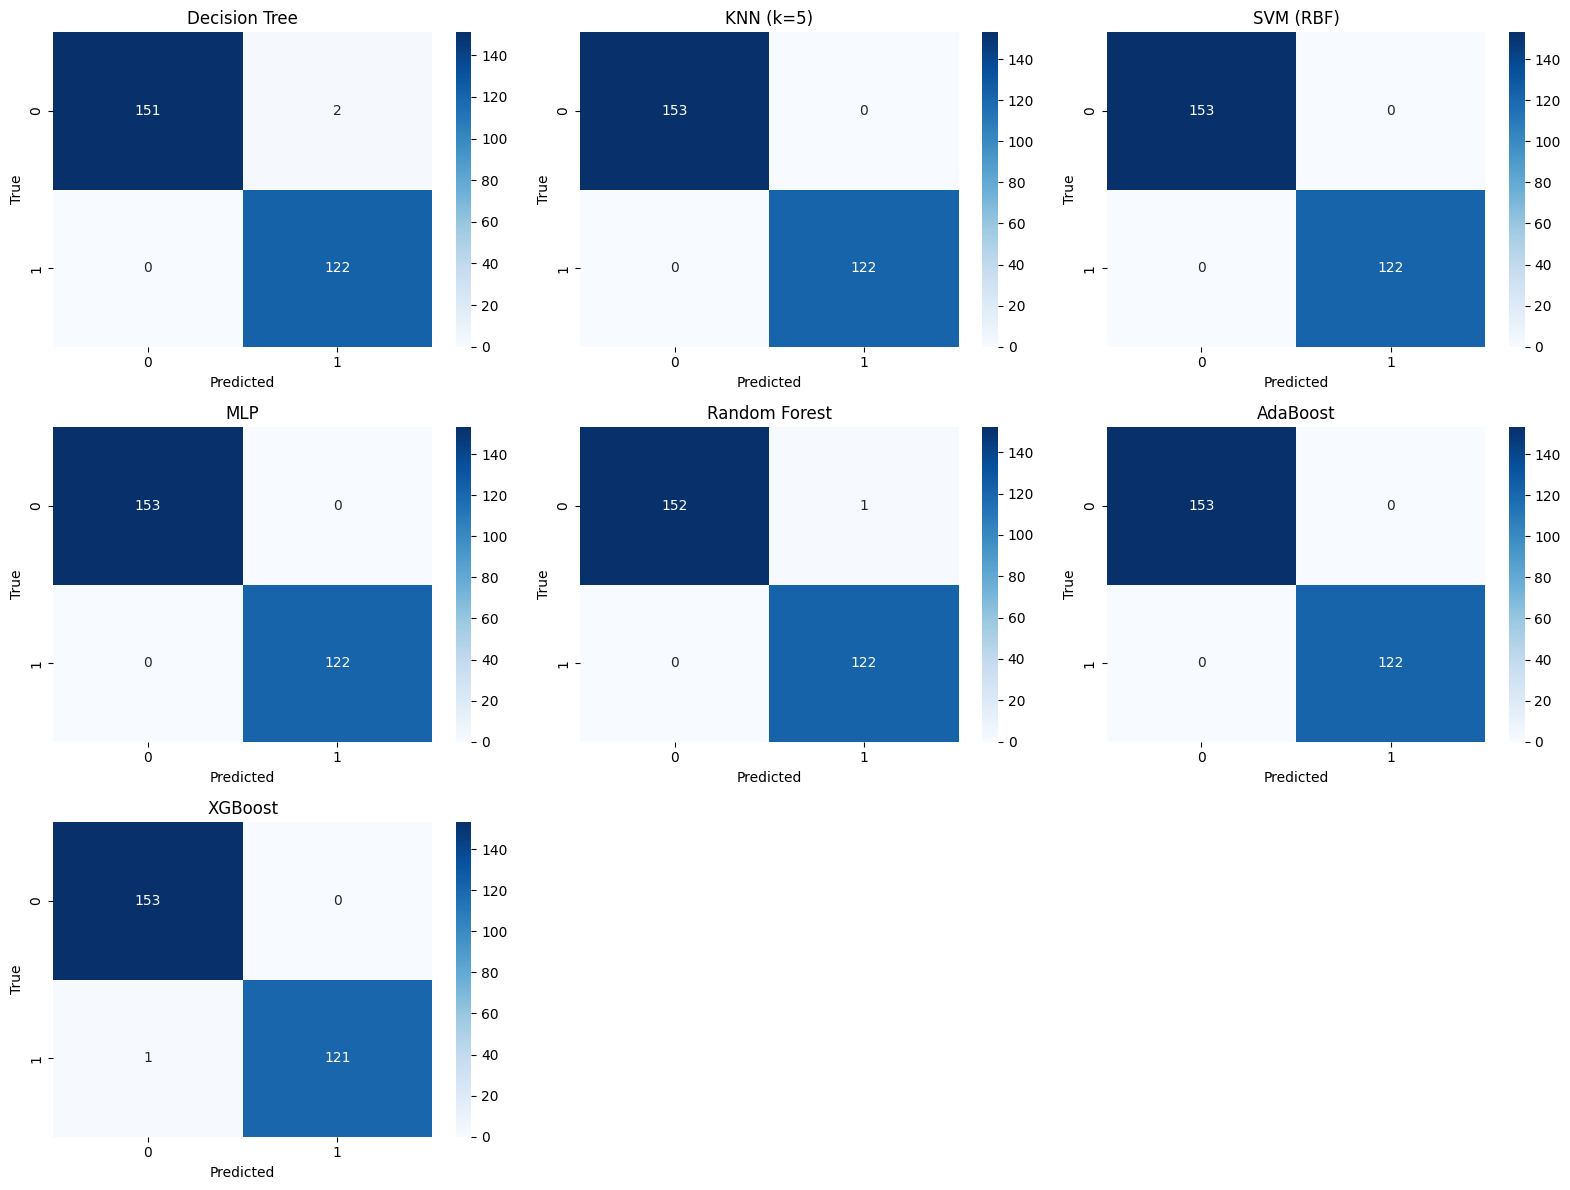

In [124]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, (name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

# nascondi subplot vuoti
for j in range(len(conf_matrices), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

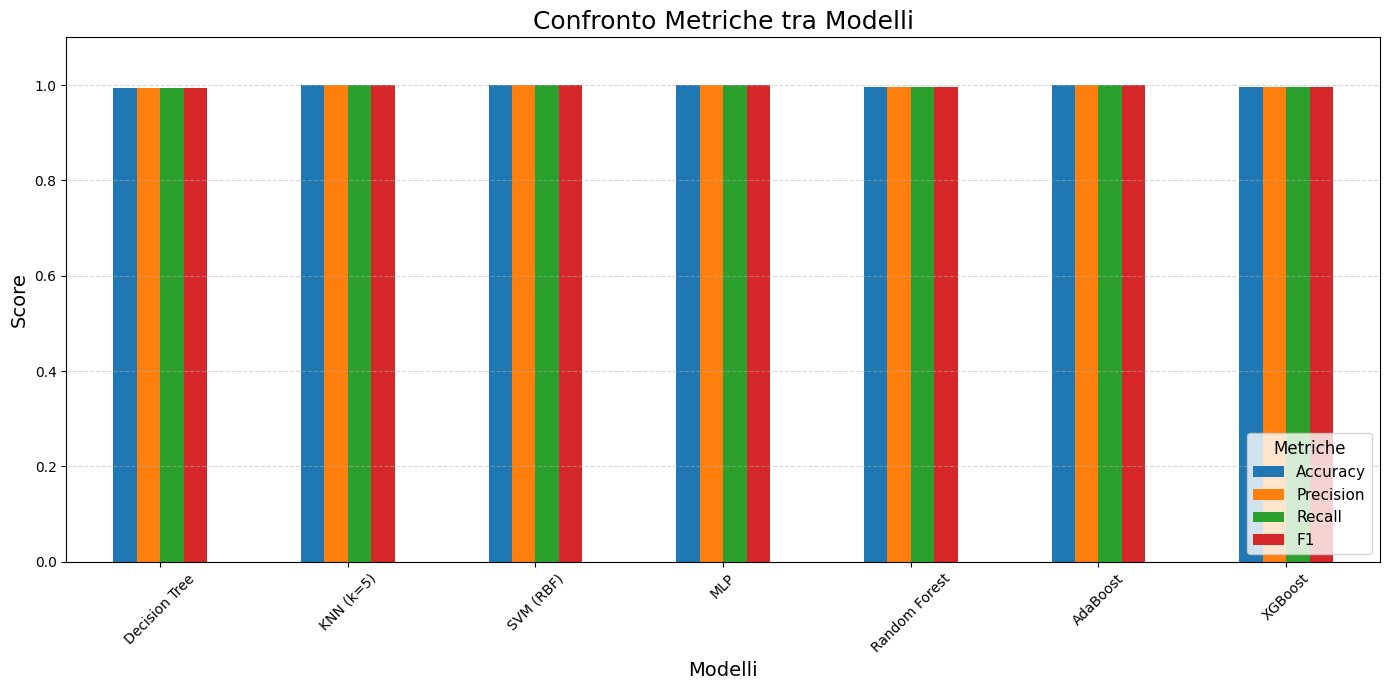

In [125]:
plt.figure(figsize=(14, 7))
df_results.plot(kind='bar', figsize=(14, 7), rot=45)

plt.title("Confronto Metriche tra Modelli", fontsize=18)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Modelli", fontsize=14)
plt.ylim(0, 1.10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.legend(title='Metriche', fontsize=11, title_fontsize=12, loc='lower right')

plt.tight_layout()
plt.show()